# Building a JAX ray marching rendering engine
7/14/20
<br/>
<br/>
<br/>

A rendering engine is essentially something that converts a scene into an image.
In this post, we'll be building one using the *ray marching* algorithm.

<table class="notebook-buttons">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/sharadvikram.com/blob/master/public/Ray_Marching_Blog_Post.ipynb""><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/sharadmv/sharadvikram.com/blob/master/public/Ray_Marching_Blog_Post.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [ ]:
!pip install jax jaxlib --upgrade -q

In [ ]:
import abc
from functools import partial
from typing import Any, List

import dataclasses
import jax
from jax import jit, vmap, grad, lax
import jax.numpy as jnp
import matplotlib.pyplot as plt

Vector = Point = Color = Scalar = Image = Any

## Introduction

### What is JAX?

## Building a scene

In [ ]:
def normalize(x):
  return x / jnp.linalg.norm(x)
  
def color_from_hex(x):
  return jnp.array([int(x[1:3], 16), int(x[3:5], 16), int(x[5:], 16)]) / 255.

## Primitives

In [ ]:
@dataclasses.dataclass
class Material:
  color: Color = jnp.array([1., 0., 0.])
  diffuse: float = 1.0
  specular: float = 1.0
  reflection: float = 0.05

In [ ]:
class Renderable(metaclass=abc.ABCMeta):

  @abc.abstractmethod
  def material_at(self, point: Point) -> Material:
    pass

  @abc.abstractmethod
  def sdf(self, point: Point) -> Scalar:
    pass
  
  def normal(self, point: Point) -> Vector:
    return grad(self.sdf)(point)

In [ ]:
@dataclasses.dataclass
class Sphere(Renderable):
  radius: float
  material: Material = Material()

  def material_at(self, point):
    return self.material

  def sdf(self, point):
    return jnp.linalg.norm(point) - self.radius

In [225]:
@dataclasses.dataclass
class Ray:
  point: Point
  direction: Vector

  def normalize(self):
    return Ray(self.point, self.direction / jnp.linalg.norm(self.direction))


@dataclasses.dataclass
class Light:
  point: Point
  color: Color

Latex test
$$
f(x) = x^2
$$

In [226]:
print('hello')
print('world')

hello
world


In [223]:
jax.tree_util.register_pytree_node(
  Ray,
  lambda ray: ((ray.point, ray.direction), ()),
  lambda _, xs: Ray(*xs)
)


jax.tree_util.register_pytree_node(
  Light,
  lambda light: ((light.point, light.color), ()),
  lambda _, xs: Light(*xs)
)

In [ ]:
@dataclasses.dataclass
class Scene:
  obj: Renderable
  lights: Light
  width: int = 640
  height: int = 480
  camera_distance: float = 1.

  def default_color(self, ray: Ray) -> Color:
    ray = ray.normalize()
    t = 0.5 * (ray.direction[1] + 1.0)
    return (1 - t) * jnp.ones(3) + t * color_from_hex('#87C1FF')

In [ ]:
@dataclasses.dataclass
class SimpleRenderingEngine:
  max_bounces: int = 5
  max_steps: int = 100
  collision_tolerance: float = 1e-3

  def render(self, scene: Scene) -> Image:
    pixel_grid = self.get_pixel_grid(scene)
    # Do a double vmap to render each pixel
    return jit(vmap(vmap(partial(self.render_pixel, scene))))(pixel_grid)

  def get_pixel_grid(self, scene: Scene) -> Any:
    aspect_ratio = scene.width / scene.height
    x = jnp.linspace(-1., 1., scene.width)
    y = jnp.linspace(1 / aspect_ratio, -1. / aspect_ratio, scene.height)
    X, Y = jnp.meshgrid(x, y)
    return X, Y
  
  def render_pixel(self, scene, pixel):
    x, y = pixel
    camera_origin = jnp.array([0., 0., -scene.camera_distance])
    camera_direction = jnp.array([x, y, 0.]) - camera_origin
    ray = Ray(camera_origin, camera_direction).normalize()
    return self.march(ray, scene)

  def march(self, ray: Ray, scene: Scene, depth: int = 0) -> Color:
    def body(carry):
      ray, distance, step_count = carry
      new_ray = Ray(ray.point + distance * ray.direction, ray.direction)
      new_distance = scene.obj.sdf(new_ray.point)
      return new_ray, new_distance, step_count + 1
    def cond(carry):
      _, distance, step_count = carry
      return (distance > self.collision_tolerance) & (step_count < self.max_steps)
    initial_distance = scene.obj.sdf(ray.point)
    final_ray, final_distance, _ = lax.while_loop(
        cond, body, (ray, initial_distance, 0))
    color = jnp.where(
        final_distance < self.collision_tolerance,
        self.color_at(final_ray, scene),
        scene.default_color(final_ray)
    )
    return color

  def color_at(self, ray: Ray, scene: Scene) -> Color:
    return scene.obj.material_at(ray.point).color

In [ ]:
scene = Scene(Sphere(0.5), Light(jnp.array([[0., 1., -2.]]), jnp.array([[0., 0., 0.]])))

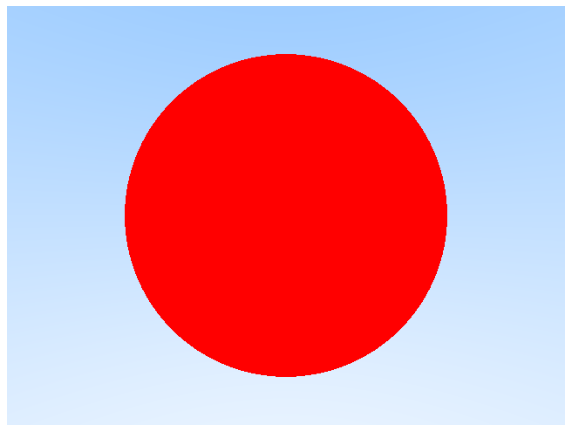

In [221]:
engine = SimpleRenderingEngine()
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(engine.render(scene));

In [ ]:
class FancyRenderingEngine(SimpleRenderingEngine):

  def color_at(self, ray: Ray, scene: Scene) -> Color:
    hit_point = ray.point
    hit_normal = scene.obj.normal(hit_point)
    material = scene.obj.material_at(hit_point)
    obj_color = material.color
    camera_vec = jnp.array([0., 0., -scene.camera_distance]) - hit_point
    base_color = jnp.array([0., 0., 0.])
    light_rays = vmap(lambda light: Ray(hit_point, light.point - hit_point).normalize())(scene.lights)
    lambert = vmap(lambda light_ray: obj_color * material.diffuse * jnp.maximum(
      hit_normal.dot(light_ray.direction), 0.
    ))(light_rays)
    half_vecs = vmap(lambda light_ray: normalize(light_ray.direction + camera_vec))(light_rays)
    specular = vmap(lambda light, half_vec: light.color * material.specular * jnp.maximum(
      hit_normal.dot(half_vec), 0.
    ) ** 50)(scene.lights, half_vecs)
    return (base_color + jnp.sum(specular, axis=0) + jnp.sum(lambert, axis=0))

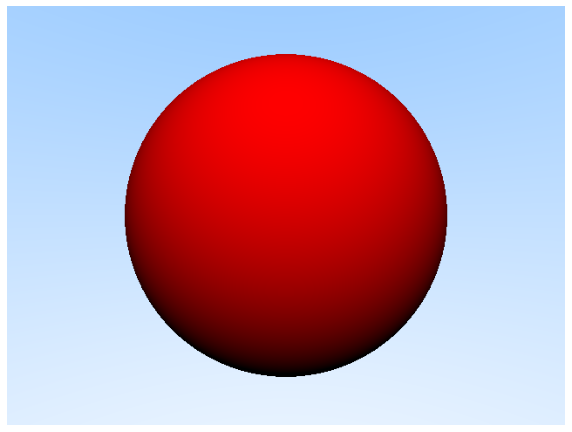

In [ ]:
engine = FancyRenderingEngine()
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(engine.render(scene));